<i>Copyright (c) Microsoft Corporation.</i>

<i>Licensed under the MIT License.</i>

# Dilated Convolutional Neural Network (CNN)

This notebook introduces Dilated Convolutional Neural Network (CNN) model and carries out multi-round training and evaluation of this model on the Orange Juice dataset.

The Dilated CNN is built upon dilated causal convolution inspired by [WaveNet](https://arxiv.org/abs/1609.03499). [Recently study](https://arxiv.org/abs/1803.01271) shows that it outperforms canonical recurrent networks such as LSTMs over a diverse range of tasks and datasets. Dilated CNN has many advantages when handling sequential data like time series
* Capturing long-range input information with less parameters
* Handling temporal flow with causal connection structures
* Better training efficiency than recurrent neural networks

Dilated CNN has been applied in several machine learning competitions and achieved impressive performance, e.g. [the Favorita Grocery Sales Forecasting competition](https://github.com/LenzDu/Kaggle-Competition-Favorita).

## Global Settings and Imports

In [1]:
%load_ext tensorboard
# %load_ext blackcellmagic

In [3]:
import os
import sys
import math
import random
import datetime
import warnings
import subprocess

import numpy as np
import pandas as pd
import tensorflow as tf
import scrapbook as sb

from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

from fclib.common.utils import git_repo_path
from fclib.dataset.ojdata import download_ojdata, split_train_test, FIRST_WEEK_START
from fclib.feature_engineering.feature_utils import (
    week_of_month,
    df_from_cartesian_product,
    gen_sequence_array,
    static_feature_array,
    normalize_dataframe,
)
from fclib.models.dilated_cnn import create_dcnn_model
from fclib.evaluation.evaluation_utils import MAPE
from fclib.common.plot import plot_predictions_with_history

warnings.filterwarnings("ignore")

print("System version: {}".format(sys.version))
print("TensorFlow version: {}".format(tf.__version__))

System version: 3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 21:14:29) 
[GCC 7.3.0]
TensorFlow version: 2.0.0


## Parameters

In [4]:
# Use False if you've already downloaded and split the data
DOWNLOAD_SPLIT_DATA = False  # True

# # Data directory
# DATA_DIR = os.path.join(git_repo_path(), "ojdata")

# Forecasting settings
N_SPLITS = 10
HORIZON = 2
GAP = 2
FIRST_WEEK = 40
LAST_WEEK = 156

In [5]:
# Data paths
DATA_DIR = os.path.join(git_repo_path(), "ojdata")
# SUBMISSION_DIR = "."
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

# Data parameters
MAX_STORE_ID = 137
MAX_BRAND_ID = 11

# Parameters of the model
# RANGE_WITH_GAP = HORIZON + GAP - 1
# PRED_STEPS = 2
SEQ_LEN = 15
DROPOUT_RATE = 0.01
DYNAMIC_FEATURES = ["deal", "feat", "month", "week_of_month", "price", "price_ratio"]
STATIC_FEATURES = ["store", "brand"]

# Parameters of training algorithm
BATCH_SIZE = 64
LEARNING_RATE = 0.015
EPOCHS = 25

## Data Preparation

In [6]:
if DOWNLOAD_SPLIT_DATA:
    download_ojdata(DATA_DIR)
    split_train_test(
        DATA_DIR,
        n_splits=N_SPLITS,
        horizon=HORIZON,
        gap=GAP,
        first_week=FIRST_WEEK,
        last_week=LAST_WEEK,
        write_csv=True,
    )
    print("Finished data downloading and splitting.")

In [7]:
# Model definition
model = create_dcnn_model(seq_len=SEQ_LEN, n_input_series=1 + len(DYNAMIC_FEATURES), n_outputs=HORIZON)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15, 7)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 15, 3)        45          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 15, 3)        21          conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 15, 3)        21          conv1d_1[0][0]                   
______________________________________________________________________________________________

In [8]:
# Fix random seeds
np.random.seed(4)
random.seed(4)
tf.random.set_seed(4)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train models and make predictions
pred_all = []
combined_all = []
metric_all = []
# file_name = os.path.join(SUBMISSION_DIR, "dcnn_model.h5")
file_name = "dcnn_model.h5"
for r in range(5):  # range(N_SPLITS):
    print("---- Round " + str(r + 1) + " ----")
    offset = 0 if r == 0 else 40 + r * HORIZON
    # Load training data
    train_df = pd.read_csv(os.path.join(TRAIN_DIR, "train_" + str(r + 1) + ".csv"))
    train_df["move"] = train_df["logmove"].apply(lambda x: round(math.exp(x)))
    # print(train_df.head(3))
    # print('')
    train_df = train_df[["store", "brand", "week", "move"]]

    # Create a dataframe to hold all necessary data
    store_list = train_df["store"].unique()
    brand_list = train_df["brand"].unique()
    train_end_week = train_df["week"].max()
    week_list = range(FIRST_WEEK + offset, train_end_week + GAP + HORIZON)
    d = {"store": store_list, "brand": brand_list, "week": week_list}
    data_grid = df_from_cartesian_product(d)
    data_filled = pd.merge(data_grid, train_df, how="left", on=["store", "brand", "week"])

    # Get future price, deal, and advertisement info
    aux_df = pd.read_csv(os.path.join(TRAIN_DIR, "aux_" + str(r + 1) + ".csv"))
    data_filled = pd.merge(data_filled, aux_df, how="left", on=["store", "brand", "week"])
    # print('Number of missing rows is {}'.format(data_filled[data_filled.isnull().any(axis=1)].shape[0]))
    # print('')

    # Create relative price feature
    price_cols = [
        "price1",
        "price2",
        "price3",
        "price4",
        "price5",
        "price6",
        "price7",
        "price8",
        "price9",
        "price10",
        "price11",
    ]
    data_filled["price"] = data_filled.apply(lambda x: x.loc["price" + str(int(x.loc["brand"]))], axis=1)
    data_filled["avg_price"] = data_filled[price_cols].sum(axis=1).apply(lambda x: x / len(price_cols))
    data_filled["price_ratio"] = data_filled["price"] / data_filled["avg_price"]
    data_filled.drop(price_cols, axis=1, inplace=True)

    # Fill missing values
    data_filled = data_filled.groupby(["store", "brand"]).apply(
        lambda x: x.fillna(method="ffill").fillna(method="bfill")
    )
    # print(data_filled.head(3))
    # print('')

    # Create datetime features
    data_filled["week_start"] = data_filled["week"].apply(
        lambda x: FIRST_WEEK_START + datetime.timedelta(days=(x - 1) * 7)
    )
    # data_filled['year'] = data_filled['week_start'].apply(lambda x: x.year)
    data_filled["month"] = data_filled["week_start"].apply(lambda x: x.month)
    data_filled["week_of_month"] = data_filled["week_start"].apply(lambda x: week_of_month(x))
    data_filled["day"] = data_filled["week_start"].apply(lambda x: x.day)
    data_filled.drop("week_start", axis=1, inplace=True)

    # Normalize the dataframe of features
    cols_normalize = data_filled.columns.difference(["store", "brand", "week"])
    data_scaled, min_max_scaler = normalize_dataframe(data_filled, cols_normalize)
    # data_scaled.head()

    # Create sequence array for 'move'
    start_timestep = 0
    end_timestep = train_end_week - FIRST_WEEK - HORIZON - GAP + 1
    train_input1 = gen_sequence_array(
        data_scaled, SEQ_LEN, ["move"], "store", "brand", start_timestep, end_timestep - offset
    )
    # train_input1.shape

    # Create sequence array for other dynamic features
    start_timestep = HORIZON + GAP - 1
    end_timestep = train_end_week - FIRST_WEEK
    train_input2 = gen_sequence_array(
        data_scaled, SEQ_LEN, DYNAMIC_FEATURES, "store", "brand", start_timestep, end_timestep - offset
    )
    # train_input2.shape

    seq_in = np.concatenate((train_input1, train_input2), axis=2)
    # seq_in.shape

    # Create array of static features
    total_timesteps = train_end_week - FIRST_WEEK - SEQ_LEN - HORIZON - GAP + 3
    cat_fea_in = static_feature_array(data_filled, total_timesteps - offset, STATIC_FEATURES, "store", "brand")
    # cat_fea_in.shape

    # Create training output
    start_timestep = SEQ_LEN + GAP - 1
    end_timestep = train_end_week - FIRST_WEEK
    train_output = gen_sequence_array(
        data_filled, HORIZON, ["move"], "store", "brand", start_timestep, end_timestep - offset
    )
    train_output = np.squeeze(train_output)
    # train_output.shape

    # Create and train model
    if r == 0:
        model = create_dcnn_model(
            seq_len=SEQ_LEN, n_filters=2, n_input_series=1 + len(DYNAMIC_FEATURES), n_outputs=HORIZON
        )
        adam = optimizers.Adam(lr=LEARNING_RATE)
        model.compile(loss="mape", optimizer=adam, metrics=["mape"])
        # Define checkpoint and fit model
        checkpoint = ModelCheckpoint(file_name, monitor="loss", save_best_only=True, mode="min", verbose=1)
        callbacks_list = [checkpoint, tensorboard_callback]
        history = model.fit(
            [seq_in, cat_fea_in],
            train_output,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=callbacks_list,
            verbose=1,
        )
    else:
        model = load_model(file_name)
        checkpoint = ModelCheckpoint(file_name, monitor="loss", save_best_only=True, mode="min", verbose=1)
        callbacks_list = [checkpoint]
        history = model.fit(
            [seq_in, cat_fea_in], train_output, epochs=1, batch_size=BATCH_SIZE, callbacks=callbacks_list, verbose=1
        )

    # Get expected test output
    test_df = pd.read_csv(os.path.join(TEST_DIR, "test_" + str(r + 1) + ".csv"))
    test_df["actual"] = test_df["logmove"].apply(lambda x: round(math.exp(x)))
    test_df.drop("logmove", axis=1, inplace=True)

    exp_output = data_filled[data_filled.week >= train_end_week + GAP].reset_index(drop=True)
    exp_output = exp_output[["store", "brand", "week"]]
    exp_output = pd.merge(exp_output, test_df, on=["store", "brand", "week"], how="left")

    start_timestep = 0
    end_timestep = HORIZON - 1
    exp_test_output = gen_sequence_array(
        exp_output, HORIZON, ["actual"], "store", "brand", start_timestep, end_timestep
    )
    exp_test_output = np.squeeze(exp_test_output)

    # Get inputs for prediction
    start_timestep = train_end_week - FIRST_WEEK - SEQ_LEN + 1
    end_timestep = train_end_week - FIRST_WEEK
    test_input1 = gen_sequence_array(
        data_scaled, SEQ_LEN, ["move"], "store", "brand", start_timestep - offset, end_timestep - offset
    )

    start_timestep = train_end_week + GAP + HORIZON - FIRST_WEEK - SEQ_LEN
    end_timestep = train_end_week + GAP + HORIZON - FIRST_WEEK - 1
    test_input2 = gen_sequence_array(
        data_scaled, SEQ_LEN, DYNAMIC_FEATURES, "store", "brand", start_timestep - offset, end_timestep - offset
    )

    print("shape of test_input1 and test_input2")
    print(test_input1.shape)
    print(test_input2.shape)
    seq_in = np.concatenate((test_input1, test_input2), axis=2)

    total_timesteps = 1
    cat_fea_in = static_feature_array(data_filled, total_timesteps, STATIC_FEATURES, "store", "brand")

    # Make prediction
    pred = np.round(model.predict([seq_in, cat_fea_in]))

    # Create dataframe for submission
    pred_df = (
        exp_output.sort_values(["store", "brand", "week"]).loc[:, ["store", "brand", "week"]].reset_index(drop=True)
    )
    pred_df["round"] = r + 1
    pred_df["prediction"] = np.reshape(pred, (pred.size, 1))

    pred_all.append(pred_df)

pred_all = pd.concat(pred_all, axis=0)
pred_all.rename(columns={"move": "prediction"}, inplace=True)
pred_all = pred_all[["round", "week", "store", "brand", "prediction"]]

---- Round 1 ----
Train on 72127 samples
Epoch 1/25
71488/72127 [============================>.] - ETA: 0s - loss: 56.3009 - mape: 56.3009
Epoch 00001: loss improved from inf to 56.21956, saving model to dcnn_model.h5
72127/72127 [==============================] - 5s 68us/sample - loss: 56.2196 - mape: 56.2196
Epoch 2/25
72000/72127 [============================>.] - ETA: 0s - loss: 47.3175 - mape: 47.3175
Epoch 00002: loss improved from 56.21956 to 47.31129, saving model to dcnn_model.h5
72127/72127 [==============================] - 4s 49us/sample - loss: 47.3113 - mape: 47.3113
Epoch 3/25
71296/72127 [============================>.] - ETA: 0s - loss: 45.8075 - mape: 45.8075
Epoch 00003: loss improved from 47.31129 to 45.82238, saving model to dcnn_model.h5
72127/72127 [==============================] - 4s 49us/sample - loss: 45.8224 - mape: 45.8224
Epoch 4/25
71232/72127 [============================>.] - ETA: 0s - loss: 44.2000 - mape: 44.2000
Epoch 00004: loss improved from 45.822

35607/35607 [==============================] - 2s 65us/sample - loss: 34.0717 - mape: 34.0717
shape of test_input1 and test_input2
(913, 15, 1)
(913, 15, 6)


In [9]:
tensorboard_path = subprocess.check_output("which tensorboard", shell=True)

tensorboard_path = tensorboard_path.decode("utf-8")[:-1]

os.environ["TENSORBOARD_BINARY"] = tensorboard_path

In [10]:
tensorboard_path

'/data/anaconda/envs/forecasting_env/bin/tensorboard'

In [11]:
%tensorboard --logdir logs/fit --port 6008

Reusing TensorBoard on port 6008 (pid 24426), started 15:50:13 ago. (Use '!kill 24426' to kill it.)

## Model Evaluation

To evaluate the performance of the model, we compute MAPE of the forecasts from all the forecast rounds below.

In [12]:
# Evaluate prediction accuracy
test_all = []
test_dir = os.path.join(DATA_DIR, "test")
for r in range(1, N_SPLITS + 1):
    test_df = pd.read_csv(os.path.join(test_dir, "test_" + str(r) + ".csv"))
    test_all.append(test_df)
test_all = pd.concat(test_all, axis=0).reset_index(drop=True)
test_all["actual"] = test_all["logmove"].apply(lambda x: round(math.exp(x)))
test_all.drop("logmove", axis=1, inplace=True)
combined = pd.merge(pred_all, test_all, on=["store", "brand", "week"], how="left")
metric_value = MAPE(combined["prediction"], combined["actual"]) * 100
sb.glue("MAPE", metric_value)
print("MAPE of the predictions is {}".format(metric_value))

MAPE of the predictions is 36.684422494588205


## Result Visualization

Let's visually check the forecasts by plotting out the forecast results of a few sample store-brand combinations.

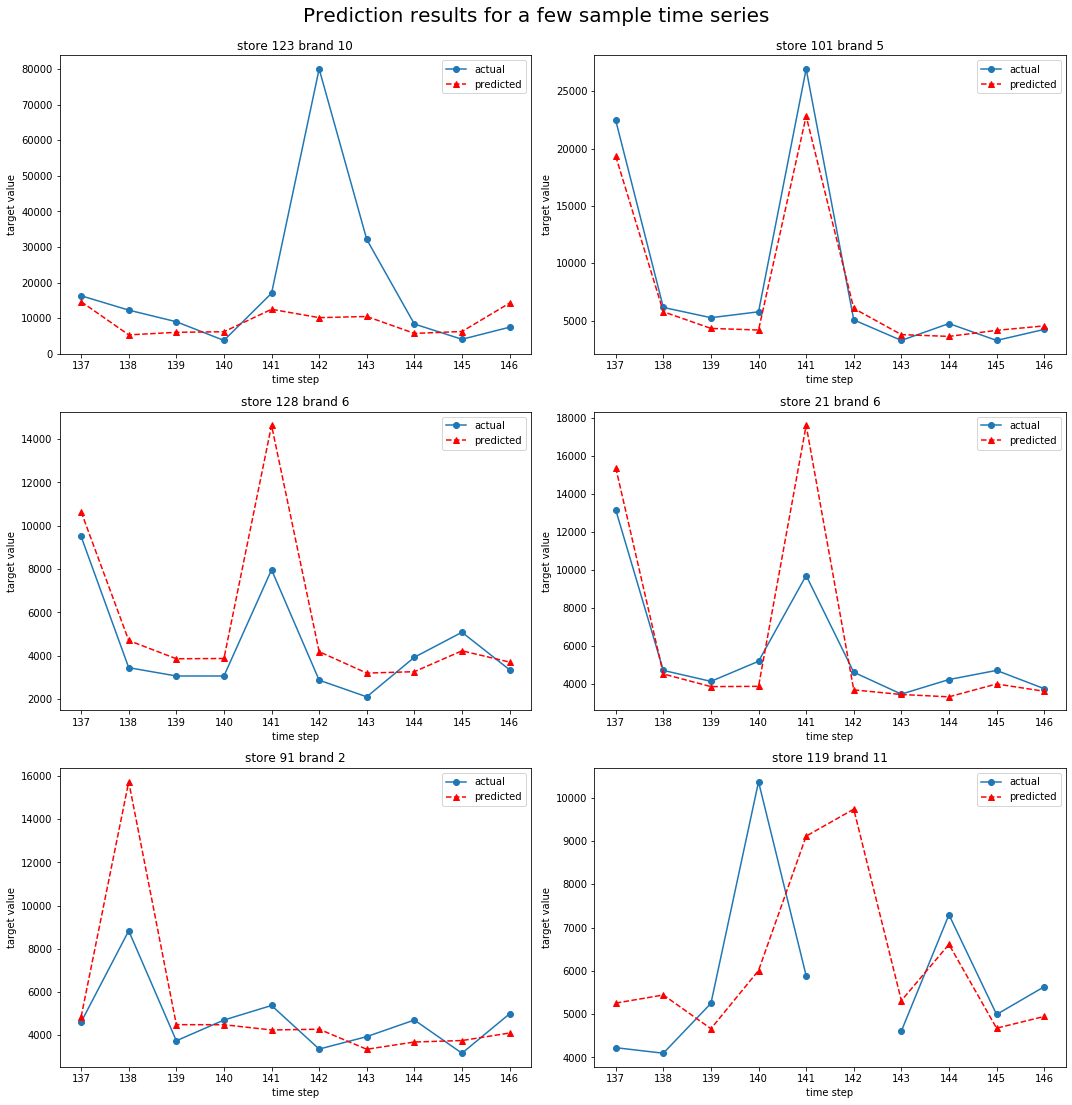

In [13]:
results = combined[["week", "store", "brand", "prediction"]]
results.rename(columns={"prediction": "move"}, inplace=True)
actual = combined[["week", "store", "brand", "actual"]]
actual.rename(columns={"actual": "move"}, inplace=True)
store_list = combined["store"].unique()
brand_list = combined["brand"].unique()

plot_predictions_with_history(
    results,
    actual,
    store_list,
    brand_list,
    "week",
    "move",
    grain1_name="store",
    grain2_name="brand",
    min_timestep=137,
    num_samples=6,
    predict_at_timestep=135,
    line_at_predict_time=False,
    title="Prediction results for a few sample time series",
    x_label="time step",
    y_label="target value",
    random_seed=6,
)

## Additional Reading

\[1\] Aaron van den Oord, Sander Dieleman, Heiga Zen, Karen Simonyan, Oriol Vinyals, Alex Graves, Nal Kalchbrenner, Andrew Senior, and Koray Kavukcuoglu. 2016. WaveNet: A Generative Model for Raw Audio. arXiv preprint
arXiv:1609.03499 (2016)<br>

\[2\] Shaojie Bai, J. Zico Kolter, and Vladlen Koltun. 2018. An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling. arXiv preprint arXiv:1803.01271 (2018)<br>